In [24]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
import json
import os
from tensorflow.keras.models import save_model

def save_model_and_history(model, history, base_dir, model_name="final_model"):
    os.makedirs(base_dir, exist_ok=True)

    # Save model
    model_path = os.path.join(base_dir, f"{model_name}.keras")
    save_model(model, model_path)

    # Save history
    history_path = os.path.join(base_dir, f"{model_name}_history.json")
    with open(history_path, "w") as f:
        json.dump(history.history, f)

    print(f"✅ Model saved to: {model_path}")
    print(f"✅ History saved to: {history_path}")

#120 Class Breeds

----------------------------------------------------------------------------

## Preparing Dataset

Pipeline:

1- Load Dataset from tensorflow

2- Display dataset

3- Resize Images to 150x150

4- Normalize pixel values to 0-1

5 - Load Dataset

6 - Create 2 version of dataset (Aug , No Aug)

In [33]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [34]:
train_ds, val_ds, test_ds = tfds.load(
    "stanford_dogs",
    split=["train[:60%]", "train[60%:90%]", "train[90%:]"],
    as_supervised=True
)


print(train_ds.cardinality(), val_ds.cardinality(), test_ds.cardinality())

tf.Tensor(7200, shape=(), dtype=int64) tf.Tensor(3600, shape=(), dtype=int64) tf.Tensor(1200, shape=(), dtype=int64)


During training ,  Validation accuracy is always stable after the 6th epoch , that made me rethink the split from 80-10-10 to 70-20-10 , i think that validation needs more samples for a longer trainig time stability ,


Last resort to avert the overfitting problem i will change the split to :

60 - 30 - 10

**Augmentation**

In [35]:
preprocessing_layers = [
    tf.keras.layers.Resizing(150, 150),
    tf.keras.layers.Rescaling(1./255)
]

augmentation_layers = [
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.05),
    tf.keras.layers.RandomContrast(0.05)
]

def preprocess_data(image, label, augment=False):
    image = preprocessing_layers[0](image)  # Resize
    image = preprocessing_layers[1](image)  # Rescale

    if augment:
        for layer in augmentation_layers:
            image = layer(image)

    return image, label

**Special Trial**

I will try to expand the dataset and save it seperately in case it doesnt work , i will expand it by saving inside the virtual memory , The question is why i didnt expand then apply augmentation this makes sense and thats what i did and encountered an error that i sat a long time to figure out until somone on stack overflow saved me ----->  https://stackoverflow.com/questions/54678975/tensorflow-dataset-api-explanation-of-behavior , till now i dont understnad it very well

In [36]:
def expand_dataset_in_memory(ds, times, preprocess_fn):
    # Start with the first augmented copy
    combined = ds.map(lambda x, y: preprocess_fn(x, y, augment=True), num_parallel_calls=tf.data.AUTOTUNE)

    # Append additional augmented copies
    for _ in range(times - 1):
        train_ds_aug = ds.map(lambda x, y: preprocess_fn(x, y, augment=True), num_parallel_calls=tf.data.AUTOTUNE)
        combined = combined.concatenate(train_ds_aug)

    return combined

**Augmentation Techniques Applied** :

Random Flip : Flip images horizontally

RandomRotation : Rotate images by 10 degrees

RandomZoom : Apply a 2x zoom

Random Contrast : Increase pixel instensities by 20 percent

Random Translation : Translate left and right positions in the images 10 percent of





**Preprocessing** :

Augmnetation Techniques

+

Resizing to 150x150 (For DenseNEt121)

+

Rescaling : normalizing pixel values from 0-1


output is shown below

In [37]:
# No Augmentation
train_ds_no_aug = train_ds.map(lambda x, y: preprocess_data(x, y, False))

# Augmentation Applied
train_ds_aug    = train_ds.map(lambda x, y: preprocess_data(x, y, True))

special_expanded = expand_dataset_in_memory(train_ds, times=1, preprocess_fn=preprocess_data)

special_train_ds = train_ds_aug.concatenate(special_expanded)


# Those are our test and validation sets no augmentation here
val_ds          = val_ds.map(lambda x, y: preprocess_data(x, y, False))
test_ds         = test_ds.map(lambda x, y: preprocess_data(x, y, False))

In [38]:
print("Train (No Aug):", train_ds_no_aug.cardinality().numpy())
print("Train (Aug):   ", train_ds_aug.cardinality().numpy())
print("Special Dataset : ", special_train_ds.cardinality().numpy())

print("Validation:    ", val_ds.cardinality().numpy())
print("Test:          ", test_ds.cardinality().numpy())

Train (No Aug): 7200
Train (Aug):    7200
Special Dataset :  14400
Validation:     3600
Test:           1200


In [98]:
print("not Augmented")
for image, label in train_ds_no_aug.take(1):
    print("Min pixel value:", tf.reduce_min(image).numpy())
    print("Max pixel value:", tf.reduce_max(image).numpy())
    print("Mean pixel value:", tf.reduce_mean(image).numpy())
    print("Shape:", image.shape)
    break


print("\nAugmented")
for image, label in train_ds_aug.take(1):
    print("Min pixel value:", tf.reduce_min(image).numpy())
    print("Max pixel value:", tf.reduce_max(image).numpy())
    print("Mean pixel value:", tf.reduce_mean(image).numpy())
    print("Shape:", image.shape)
    break

print("\nSpecial Dataset")
for image, label in special_train_ds.take(1):
    print("Min pixel value:", tf.reduce_min(image).numpy())
    print("Max pixel value:", tf.reduce_max(image).numpy())
    print("Mean pixel value:", tf.reduce_mean(image).numpy())
    print("Shape:", image.shape)
    break

not Augmented
Min pixel value: 0.0004901662
Max pixel value: 0.9940847
Mean pixel value: 0.2108779
Shape: (150, 150, 3)

Augmented
Min pixel value: 0.0
Max pixel value: 1.0277513
Mean pixel value: 0.47759822
Shape: (32, 150, 150, 3)

Special Dataset
Min pixel value: 0.011275798
Max pixel value: 0.9700523
Mean pixel value: 0.21985295
Shape: (150, 150, 3)


In [8]:
def show_sample_images(dataset, label_names, samples=9):
    plt.figure(figsize=(10, 10))

    count = 0
    for image, label in dataset:
        ax = plt.subplot(3, 3, count + 1)

        if image.dtype == tf.float32:
            plt.imshow(image.numpy() , vmin = 0.00 , vmax=1.0)  # float normalized image
        else:
            plt.imshow(image.numpy().astype("uint8"))  # raw image

        plt.title(label_names[int(label.numpy())], fontsize=9)
        plt.axis("off")
        count += 1

        if count >= samples:
            break

    plt.tight_layout()
    plt.show()


label_names = tfds.builder("stanford_dogs").info.features["label"].names


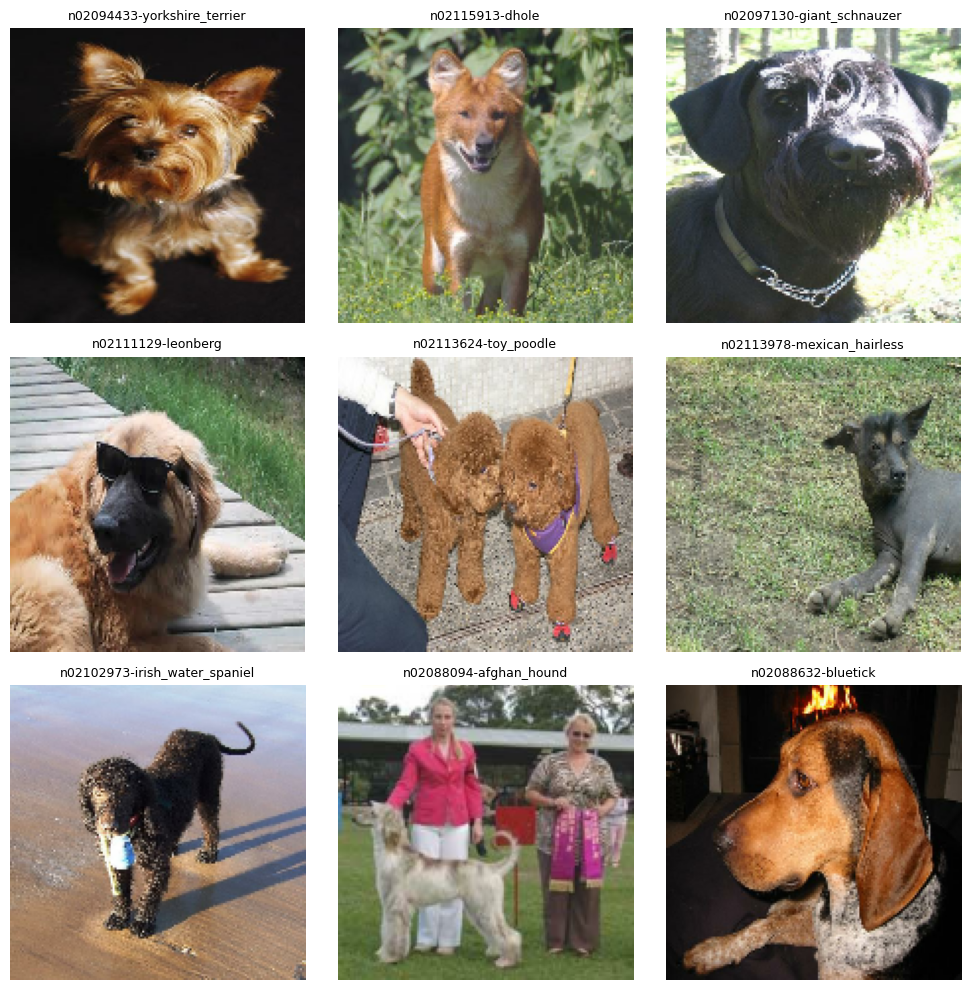

In [9]:
show_sample_images(train_ds_no_aug, label_names)  # Preprocessed only

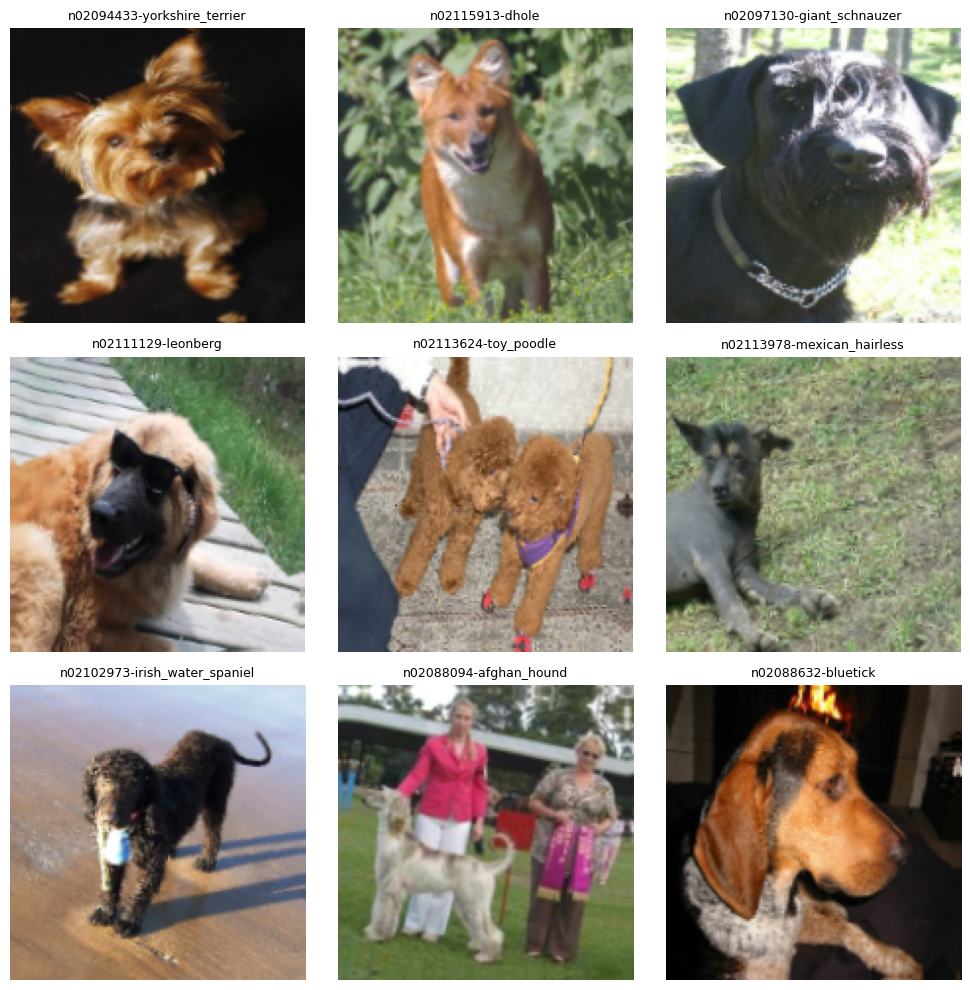

In [10]:
show_sample_images(train_ds_aug, label_names)     # Augmented + Preprocessed

It’s not breaking anything.

augmented pixel values slightly exceeded [0,1]

tf.clip_by_value() solves it instantly without me doing it manually

---------------------------------------------

## Pre-Trained Model

After Reading and trying various Models those were the Final Options :


**MobileNetV2**

**Depth/Capacity**: Shallow and lightweight

**Feature Extraction**: Weak at capturing subtle details due to reduced complexity

**Generalization on Fine-Grained Data**: Poor — lacks the representational power required for 120-class classification, leading to underfitting and lower accuracy

***10% Train accuracy - 9% Val accuracy***

----------------------------------------------
**EfficientNetB0**

**Depth/Capacity**: Balanced and optimized using compound scaling

**Feature Extraction**: Strong at multiple scales, but can still miss critical class-specific traits in shallow configurations

**Generalization**: Moderate — performs decently but may require fine-tuning and larger input sizes to truly shine in complex scenarios

***40% Train accuracy - 36% val accuracy***

----------------------------------------------
**ResNet50**

**Depth/Capacity:** Deep and widely adopted

**Feature Extraction:** Robust at extracting mid- and high-level features

**Generalization:** Stable but not exceptional without deeper tuning. Can perform well with adjusted learning rates and unfreezing

60% Train accuracy - 41% val accuracy

----------------------------------------------
**DenseNet121 (Our Sun Wukong 🐒⚔️)**

**Depth/Capacity:** Deep with efficient skip connections

**Feature Extraction:** Excellent — captures both fine-grained textures and global structures via dense reuse of features

**Generalization:** Best suited for this task — the skip-based architecture helps retain low-level cues essential for distinguishing between visually similar breeds


99% train accuracy - 60% val accuracy (at best)

----------------------------------------------

**DenseNet121**

In [40]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2

def build_custom_densenet():
    base_model = DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=(150, 150, 3)
    )
    base_model.trainable = False

    inputs = Input(shape=(150, 150, 3))
    x = preprocess_input(inputs)
    x = base_model(inputs, training=False)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Flatten()(x)


    #L2 penalizes neurons with too much influence.


    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)

    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)

    outputs = Dense(120, activation='softmax')(x)

    return Model(inputs, outputs)

**Why DenseNet ??**


I chose DenseNet121 as it offers a unique balance between feature reuse and efficiency, making it well-suited for fine-grained classification tasks like dog breeds. Unlike more commonly used models such as EfficientNetB0 or Xception ; DenseNet121 uses dense connections to improve gradient flow and ***reduce overfitting with fewer parameters***.   This makes it ideal for comparing the impact of augmentation vs. non-augmentation on model performance in a more effective way.

**Trial no.10** :

Dropout layers are a must i admit i will get over my arrogance

Dropout ranges : 0.1 , 0.2 , 0.3

**Trial no.21** :

We will try to reconstruct the architecture by removing the last 128 densenet , maybe thats why the model learns too fast .

**Trial no.42**:

 I am against the wall now and will start Fine Tuning the Model , Overfitting is not reducing no matter what i do i have to sacrifice accuracy or high loss for it to decrease , peak was 0.89 train acc. and 0.58 val acc.

Unfreezing the last 20 layers yielded : 100% accuracy  - 59% accuracy , the model is very strong but  overconfident in training i will try to increase dropout ranges and add something new

**L2 Regularization** (This saved the assignment)

penalizes large weight values.

It modifies the loss function like this:

Loss = Original Loss + λ * sum(W²)

Where:

W are the model’s weights

λ is the L2 penalty factor (e.g., 0.001)

**Final Trial**

I will try a creative approach , i will first expand the dataset then apply augmentation on it then add it to the already augmented dataset that will yield 14400 images all with randome augmentation this is the last option i will resort to fix the overfitting problem.

---------------------------------------------

### Training Without Augmentation

In [12]:
batch_size = 32

train_ds_no_aug = train_ds_no_aug.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE).cache()
val_ds = val_ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE).cache()

drop remainder = True , the dataset size is not of equal 32 batches size so i am dropping the batch if there is not enough images for it , it will only drop the last one so it wont make much of a difference

In [13]:
for images, labels in train_ds_no_aug.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Image batch shape: (32, 150, 150, 3)
Label batch shape: (32,)


In [14]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam



early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_no_aug = build_custom_densenet()

# Unfreeze some layers for fine-tuning
base_model = model_no_aug.get_layer("densenet121")
base_model.trainable = True

# Freeze most layers except the last 20
for layer in base_model.layers[:-20]:
    layer.trainable = False


model_no_aug.compile(
    optimizer=Adam(0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
history_no_aug = model_no_aug.fit(
    train_ds_no_aug,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 64s 138ms/step - accuracy: 0.0733 - loss: 5.6482 - val_accuracy: 0.2879 - val_loss: 3.9617
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.4550 - loss: 3.3426 - val_accuracy: 0.4328 - val_loss: 3.2875
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 63ms/step - accuracy: 0.6718 - loss: 2.5173 - val_accuracy: 0.4813 - val_loss: 3.0182
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.8270 - loss: 1.9604 - val_accuracy: 0.4824 - val_loss: 2.9942
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.9423 - loss: 1.5468 - val_accuracy: 0.5047 - val_loss: 2.9228
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.9894 - loss: 1.2493 - val_accuracy: 0.5061 - val_loss: 2.9188
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.9994 - loss: 1.0798 - val_accuracy: 0.5022 - val_loss: 2.9013
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 1.0000 - loss: 0.9877 -

In [16]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

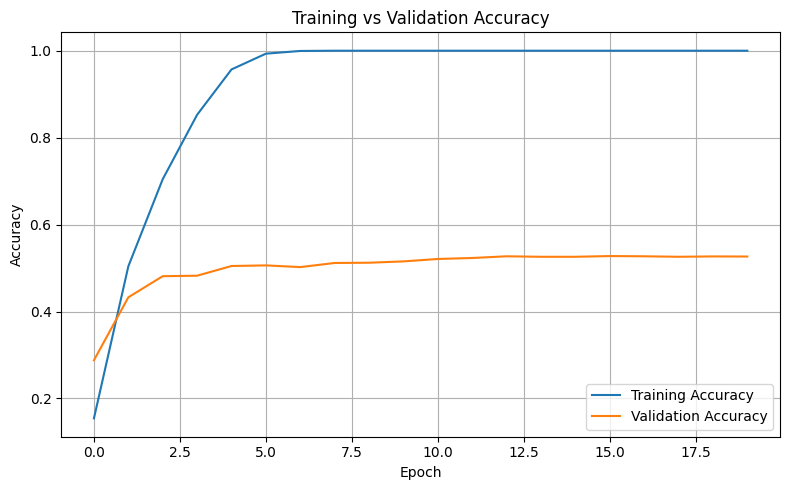

In [17]:
plot_accuracy(history_no_aug)

In [ ]:
save_model_and_history(
    model=model_no_aug,
    history=history_no_aug,
    base_dir="/content/drive/MyDrive/Assignment#2",
    model_name="No_Aug_Model"
)

✅ Model saved to: /content/drive/MyDrive/Assignment#2/No_Aug_Model.keras
✅ History saved to: /content/drive/MyDrive/Assignment#2/No_Aug_Model_history.json


----------------------------------------------

### Training With Augmentation

In [41]:
batch_size = 32

train_ds_aug = train_ds_aug.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE).cache()
val_ds = val_ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE).cache()

I dont really understand early stopping clearly but i know that it will help stop the model when val acc is not improving for a certain no of epochs , and this is what happens starting from epoch 12-15

In [42]:
for images, labels in train_ds_aug.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Image batch shape: (32, 150, 150, 3)
Label batch shape: (32,)


In [52]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam



early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_aug = build_custom_densenet()

# Unfreeze some layers for fine-tuning
base_model = model_aug.get_layer("densenet121")
base_model.trainable = True

# Freeze most layers except the last 20
for layer in base_model.layers[:-20]:
    layer.trainable = False


model_aug.compile(
    optimizer=Adam(0.00003),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [53]:
history_aug = model_aug.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 56s 116ms/step - accuracy: 0.0169 - loss: 6.2487 - val_accuracy: 0.0857 - val_loss: 5.3152
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.1530 - loss: 4.8654 - val_accuracy: 0.1956 - val_loss: 4.5465
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.3414 - loss: 3.9969 - val_accuracy: 0.2626 - val_loss: 4.1472
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.5127 - loss: 3.4008 - val_accuracy: 0.3103 - val_loss: 3.9103
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.6496 - loss: 2.9552 - val_accuracy: 0.3432 - val_loss: 3.7592
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.7577 - loss: 2.5980 - val_accuracy: 0.3636 - val_loss: 3.6544
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 69ms/step - accuracy: 0.8464 - loss: 2.3074 - val_accuracy: 0.3823 - val_loss: 3.5729
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.9070 - loss: 2.0616 -

In [54]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

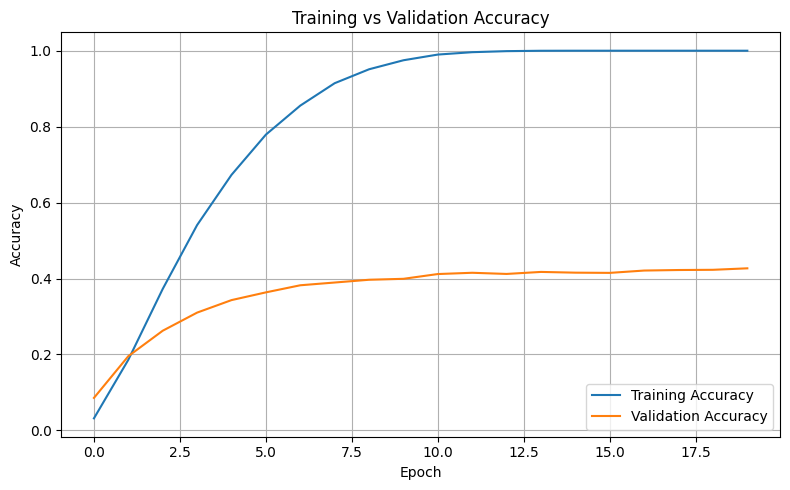

In [55]:
plot_accuracy(history_aug)

In [57]:
save_model_and_history(
    model=model_aug,
    history=history_aug,
    base_dir="/content/drive/MyDrive/Assignment#2",
    model_name="Aug_Model"
)

✅ Model saved to: /content/drive/MyDrive/Assignment#2/Aug_Model.keras
✅ History saved to: /content/drive/MyDrive/Assignment#2/Aug_Model_history.json


Training with Augmentation only yielded worse results bu the reason for that was that augmentation may have been too harsh and some samples may be distorted which worked fine when output classes were less as i said before , however here there is a new solution to that problem i call it **THE DESTINED ONE**

###Training With Augmentation + Expansion **(THE DESTINED ONE)**

In [9]:
batch_size = 32

special_train_ds = special_train_ds.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE).cache()

In [10]:
for images, labels in special_train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Image batch shape: (32, 150, 150, 3)
Label batch shape: (32,)


In [15]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam



early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_aug_exp = build_custom_densenet()

# Unfreeze some layers for fine-tuning
base_model = model_aug_exp.get_layer("densenet121")
base_model.trainable = True

# Freeze most layers except the last 20
for layer in base_model.layers[:-20]:
    layer.trainable = False


model_aug_exp.compile(
    optimizer=Adam(0.00001), # this is the smaller than usual as the no. of samples doubled and the model is too strong it will learn fast
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

I ran the model three times so thats why it shows only the last 10 epochs i didnt expect the learnign rate to be this slow but the reuslts are worth it till now

In [18]:
history_aug_exp = model_aug_exp.fit(
    special_train_ds,
    validation_data=val_ds,
    initial_epoch=30,
    epochs = 40 ,
    callbacks=[early_stop]

)

Epoch 31/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 125s 262ms/step - accuracy: 0.7964 - loss: 1.8331 - val_accuracy: 0.5578 - val_loss: 2.5529
Epoch 32/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 141s 260ms/step - accuracy: 0.7987 - loss: 1.8089 - val_accuracy: 0.5633 - val_loss: 2.5472
Epoch 33/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 125s 261ms/step - accuracy: 0.8166 - loss: 1.7513 - val_accuracy: 0.5597 - val_loss: 2.5450
Epoch 34/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 124s 260ms/step - accuracy: 0.8174 - loss: 1.7237 - val_accuracy: 0.5625 - val_loss: 2.5336
Epoch 35/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 124s 260ms/step - accuracy: 0.8257 - loss: 1.6911 - val_accuracy: 0.5658 - val_loss: 2.5277
Epoch 36/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 142s 261ms/step - accuracy: 0.8389 - loss: 1.6507 - val_accuracy: 0.5658 - val_loss: 2.5287
Epoch 37/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 123s 258ms/step - accuracy: 0.8470 - loss: 1.6160 - val_accuracy: 0.5653 - val_loss: 2.5233
Epoch 38/40
450/450 ━━━━━━━━━━━━━━━━━━━━ 123s 257ms/step - accuracy: 

“Model reached peak performance between Epochs 35–40, with highest validation accuracy at 56.78% and lowest validation loss at 2.5233. Overfitting was avoided entirely.” at the cost of accuracy this is the best i can achieve

“Sometimes it’s not the model.

Sometimes it’s not the tuning.

Sometimes… it’s just the data.”



AI didn’t shine just because of better models — it shined because we finally had the data pipelines to fuel them.


Tools like data warehouses and OLAP made large-scale data handling possible, and this project proves it: performance gains came not just from model tuning, but from smart data expansion, preprocessing, and delivery.


In deep learning, how you feed the model matters just as much as what model you use.



In [27]:
save_model_and_history(
    model=model_aug_exp,
    history=history_aug_exp,
    base_dir="/content/drive/MyDrive/Assignment#2",
    model_name="The Destined One"
)

✅ Model saved to: /content/drive/MyDrive/Assignment#2/The Destined One.keras
✅ History saved to: /content/drive/MyDrive/Assignment#2/The Destined One_history.json


I expanded the dataset in memory to increase visual diversity without introducing label noise or overfitting.


This led to slower convergence, but with significantly better generalization.
The model now sees the same dog from different angles, lighting, and contexts, allowing it to learn the defining traits of what a breed is not just one frozen image as its the same dog to me with my eyes the model probably will have a hard time too . This is the true value of augmentation and in-memory dataset expansion. (I dont know if i was allowede to do this in the assignment but we will leave it cuz i cant do anything else with that 120 class breed again i created the strongest model i could have possibly made )

**------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

#50 Class Breeds

**Subset Experiment – Reducing the Number of Output Classes**

To analyze whether overfitting is caused by high output dimensionality or not and to ensure my work was valid and the dataset was the problem , i subsetted the dataset from 120 dog breeds to 50 breeds.

- Goal: Determine if reducing class complexity improves generalization
- Reason: With fewer classes, the softmax layer has a simpler task, and the model can focus on clearer decision boundaries
- Method: I Chose 50 most represented classes (balanced and fair)

## Preparing Dataset

Pipeline:

1- Load Dataset from tensorflow

2- Display dataset

3- Resize Images to 150x150

4- Normalize pixel values to 0-1

5 - Load Dataset

6 - Create 2 version of dataset (Aug , No Aug)

In [73]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [74]:
raw_train_ds, raw_val_ds, raw_test_ds = tfds.load(
    "stanford_dogs",
    split=["train[:60%]", "train[60%:90%]", "train[90%:]"],
    as_supervised=True
)

In [75]:
from collections import Counter

label_counter = Counter()
for _, label in raw_train_ds:
    label_counter[int(label.numpy())] += 1

top_50 = sorted(label_counter.items(), key=lambda x: x[1], reverse=True)[:50]
top_50_labels = set([label for label, _ in top_50])

In [76]:
# Mapping top 50 labels to [0, 49]
label_map = {original: new for new, original in enumerate(sorted(top_50_labels))}

keys_tensor = tf.constant(list(label_map.keys()), dtype=tf.int64)
vals_tensor = tf.constant(list(label_map.values()), dtype=tf.int64)

table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
    default_value=-1
)

In [77]:
def filter_and_remap(image, label):
    label = table.lookup(label)
    return label >= 0  # Only keep labels that are in top 50

def remap_label(image, label):
    return image, table.lookup(label)

# Apply to datasets
train_ds = raw_train_ds.filter(filter_and_remap).map(remap_label)
val_ds   = raw_val_ds.filter(filter_and_remap).map(remap_label)
test_ds  = raw_test_ds.filter(filter_and_remap).map(remap_label)

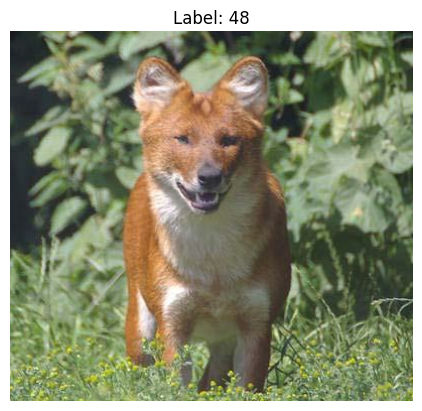

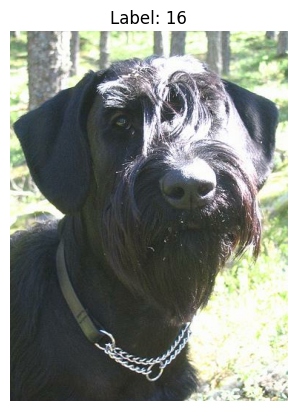

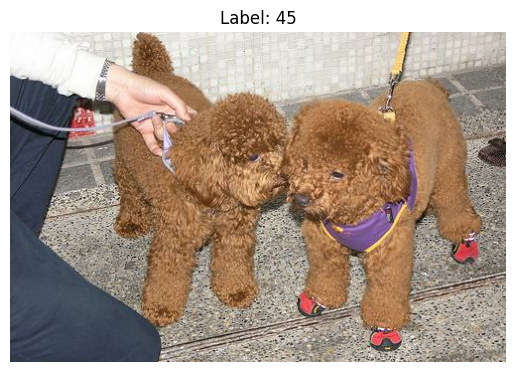

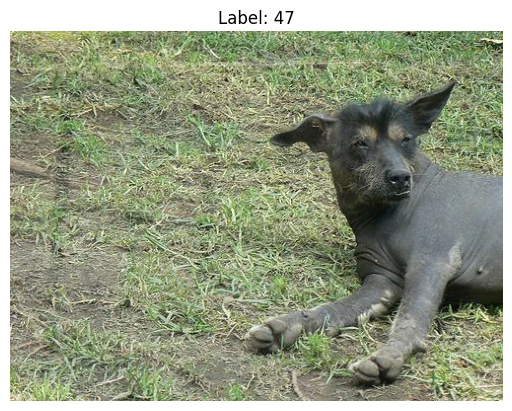

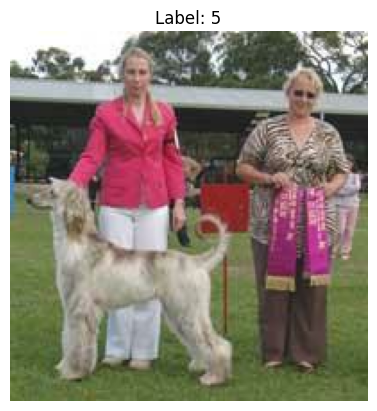

In [ ]:
import matplotlib.pyplot as plt

for image, label in train_ds.take(5):
    plt.imshow(image.numpy())
    plt.title(f"Label: {label.numpy()}")
    plt.axis("off")
    plt.show()

In [78]:
print("Train:", sum(1 for _ in train_ds))
print("Val:", sum(1 for _ in val_ds))
print("Test:", sum(1 for _ in test_ds))

Train: 3239
Val: 1308
Test: 453


Remember those values because they will be manually used

**Augmentation**

In [79]:
preprocessing_layers = [
    tf.keras.layers.Resizing(150, 150),
    tf.keras.layers.Rescaling(1./255)
]

# Stronger augmentation layers
augmentation_layers = [
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
]

def preprocess_data(image, label, augment=False):
    image.set_shape([None, None, 3])  # 💡 Ensure the shape is known

    image = preprocessing_layers[0](image)  # Resize
    image = preprocessing_layers[1](image)  # Rescale

    if augment:
        for layer in augmentation_layers:
            image = layer(image)

    return image, label

In [80]:
# No Augmentation
train_ds_no_aug_mod = train_ds.map(lambda x, y: preprocess_data(x, y, False), num_parallel_calls=tf.data.AUTOTUNE)

# Augmentation Applied
train_ds_aug_mod = train_ds.map(lambda x, y: preprocess_data(x, y, True), num_parallel_calls=tf.data.AUTOTUNE)

# Validation and Testing – No Augmentation
val_ds = val_ds.map(lambda x, y: preprocess_data(x, y, False), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: preprocess_data(x, y, False), num_parallel_calls=tf.data.AUTOTUNE)


In [81]:
print("Train (No Aug):", train_ds_no_aug_mod.cardinality().numpy())
print("Train (Aug):   ", train_ds_aug_mod.cardinality().numpy())
print("Validation:    ", val_ds.cardinality().numpy())
print("Test:          ", test_ds.cardinality().numpy())

Train (No Aug): -2
Train (Aug):    -2
Validation:     -2
Test:           -2


**This is not an error the reason for -2 is** :


TensorFlow tried to convert your raw uint8 image into float32 automatically (because Keras layers expect float32).

But because this happened inside the functionn unlike with the 120 class breed it wasnt able to count it , so dataset is not broken or modified it is just a counting mismatch

which i also sat a long time in and was saved by yet another person from stack overflow -- > https://stackoverflow.com/questions/59986353/why-do-i-have-to-convert-uint8-into-float32

In [ ]:
def show_sample_images(dataset, label_names, samples=9):
    plt.figure(figsize=(10, 10))

    count = 0
    for image, label in dataset:
        ax = plt.subplot(3, 3, count + 1)

        if image.dtype == tf.float32:
            plt.imshow(image.numpy() , vmin = 0.00 , vmax=1.0)  # float normalized image
        else:
            plt.imshow(image.numpy().astype("uint8"))  # raw image

        plt.title(label_names[int(label.numpy())], fontsize=9)
        plt.axis("off")
        count += 1

        if count >= samples:
            break

    plt.tight_layout()
    plt.show()


label_names = tfds.builder("stanford_dogs").info.features["label"].names

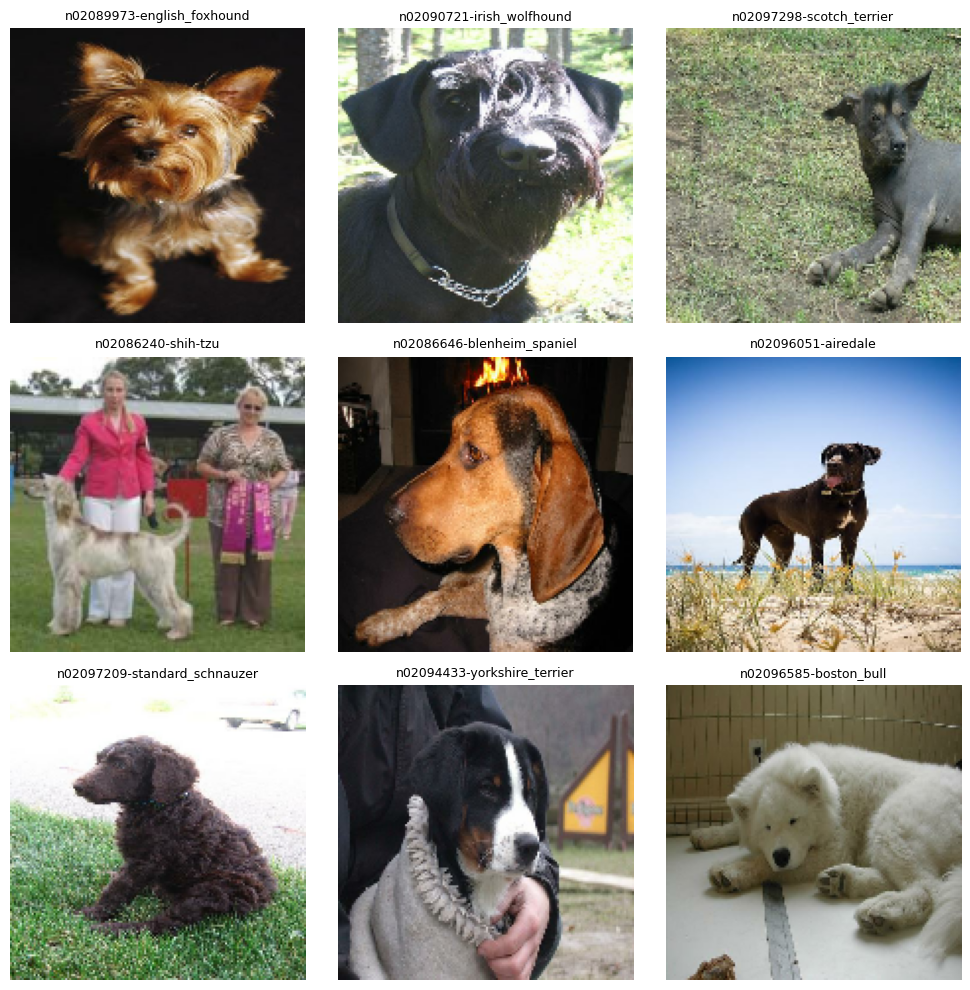

In [ ]:
show_sample_images(train_ds_no_aug_mod, label_names)  # Preprocessed only

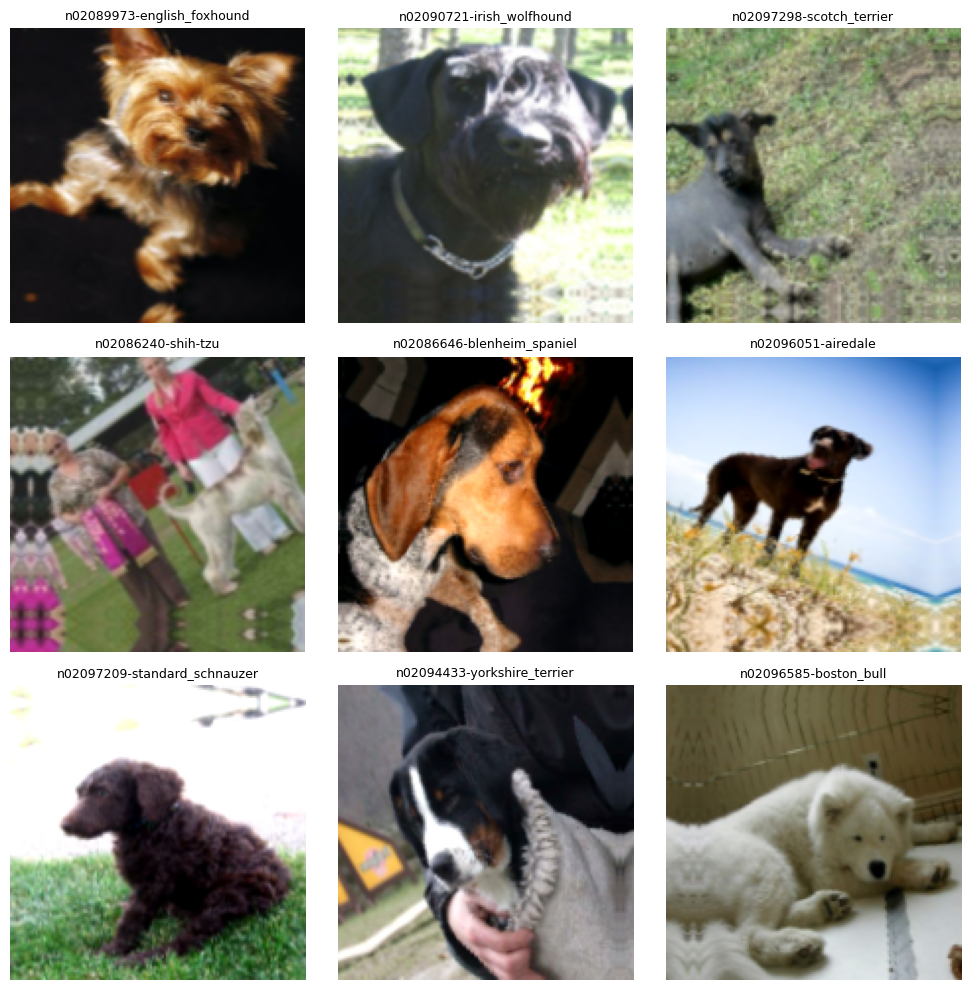

In [ ]:
show_sample_images(train_ds_aug_mod, label_names)     # Augmented + Preprocessed

## Pre-Trained Model

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2

def build_custom_densenet():
    base_model = DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=(150, 150, 3)
    )
    base_model.trainable = False

    inputs = Input(shape=(150, 150, 3))
    x = preprocess_input(inputs)
    x = base_model(inputs, training=False)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Flatten()(x)


    #L2 penalizes neurons with too much influence.


    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)

    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)

    outputs = Dense(120, activation='softmax')(x)

    return Model(inputs, outputs)

### Training Without Augmentation

I trained on a prefetched dataset that isn’t repeating by default.
And since Keras can’t auto-infer steps_per_epoch from a dataset with unknown cardinality , so i will define train size and repeat manually

In [ ]:
batch_size = 32

train_ds_no_aug_mod = train_ds_no_aug_mod.shuffle(1000).batch(batch_size).repeat().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

I will try to triple the dataset , just to try and make the training more noisy (Very bad decision the model jsut adapted faster to the data)

In [ ]:
for images, labels in train_ds_no_aug_mod.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Image batch shape: (32, 150, 150, 3)
Label batch shape: (32,)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam



early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_no_aug = build_custom_densenet()

# Unfreeze some layers for fine-tuning
base_model = model_no_aug.get_layer("densenet121")
base_model.trainable = True

# Freeze most layers except the last 20
for layer in base_model.layers[:-20]:
    layer.trainable = False


model_no_aug.compile(
    optimizer=Adam(0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# This was added because it always gives an error at the first epoch the reasoning behind this is that tensorflow is not fetching the whole data so it think that input has ran out when in fact it was just trimmed and this deosnt affect training

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
TRAIN_SIZE = 3239  # This value was printed up when we were counting samples

steps_per_epoch = TRAIN_SIZE // batch_size


history_no_aug = model_no_aug.fit(
    train_ds_no_aug_mod,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop],
    steps_per_epoch=steps_per_epoch

)

Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 97s 335ms/step - accuracy: 0.1187 - loss: 5.4155 - val_accuracy: 0.3570 - val_loss: 3.8608
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.5883 - loss: 2.9016 - val_accuracy: 0.5765 - val_loss: 2.7427
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - accuracy: 0.7528 - loss: 2.1475 - val_accuracy: 0.6476 - val_loss: 2.4219
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.8507 - loss: 1.7525 - val_accuracy: 0.6506 - val_loss: 2.3292
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.9041 - loss: 1.5155 - val_accuracy: 0.6728 - val_loss: 2.2422
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - accuracy: 0.9548 - loss: 1.3269 - val_accuracy: 0.6682 - val_loss: 2.2285
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.9803 - loss: 1.1892 - val_accuracy: 0.6858 - val_loss: 2.1775
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.9887 - loss: 1.09

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

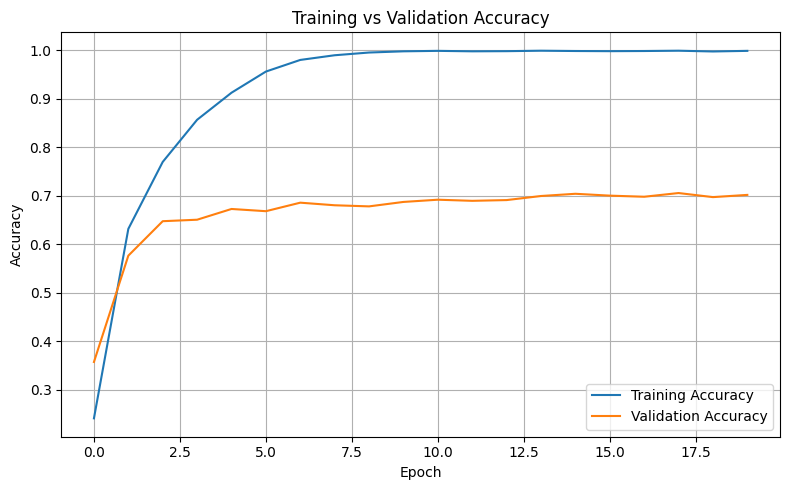

In [ ]:
plot_accuracy(history_no_aug)

In [ ]:
save_model_and_history(
    model=model_no_aug,
    history=history_no_aug,
    base_dir="/content/drive/MyDrive/Assignment#2",
    model_name="Modified_No_Aug_Model"
)

✅ Model saved to: /content/drive/MyDrive/Assignment#2/Modified_No_Aug_Model.keras
✅ History saved to: /content/drive/MyDrive/Assignment#2/Modified_No_Aug_Model_history.json


**Initial Observations:**

Training Accuracy:

Climbs fast: hits 99.97% by Epoch 20

Plateau begins after Epoch 10 → full memorization zone

Validation Accuracy:

Rises to ~70.57% by Epoch 18

Stops improving around Epoch 12

Curve flattens while training keeps going → classic overfitting signal



The model was literally memorizing as if it was studying for a Computers & Society test which is hella boring so u jsut memorize everything.


However when validating , it is like when the proffessor changes the questions and decides na lets test the understanding and get creative on a boring subject .

It failed to generalize to unseen examples because it never saw any diversity.

**Which is the aim of that assignment**


### Training With Augmentation

In [ ]:
batch_size = 32


train_ds_aug_mod = train_ds_aug_mod.shuffle(1000).batch(batch_size).repeat().prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE).cache()

In [ ]:
for images, labels in train_ds_aug_mod.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Image batch shape: (32, 150, 150, 3)
Label batch shape: (32,)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam



early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_aug = build_custom_densenet()

# Unfreezing some layers for fine-tuning
base_model = model_aug.get_layer("densenet121")
base_model.trainable = True

# Freezing most layers except the last 20
for layer in base_model.layers[:-20]:
    layer.trainable = False


model_aug.compile(
    optimizer=Adam(0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# This was added because it always gives an error at the first epoch the reasoning behind this is that tensorflow is not fetching the whole data so it think that input has ran out when in fact it was just trimmed and this deosnt affect training


import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
TRAIN_SIZE = 3239  # This value was printed up when we were counting samples

steps_per_epoch = TRAIN_SIZE  // batch_size

history_aug = model_aug.fit(
    train_ds_aug_mod,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop],
    steps_per_epoch = steps_per_epoch
)

Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 90s 527ms/step - accuracy: 0.0531 - loss: 5.7859 - val_accuracy: 0.2906 - val_loss: 4.1946
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 66s 514ms/step - accuracy: 0.3565 - loss: 3.9280 - val_accuracy: 0.5336 - val_loss: 2.9499
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 26s 264ms/step - accuracy: 0.4462 - loss: 3.3065 - val_accuracy: 0.5945 - val_loss: 2.5207
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 36s 357ms/step - accuracy: 0.5375 - loss: 2.8631 - val_accuracy: 0.6289 - val_loss: 2.3392
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 35s 351ms/step - accuracy: 0.5689 - loss: 2.7009 - val_accuracy: 0.6391 - val_loss: 2.2760
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 34s 340ms/step - accuracy: 0.6018 - loss: 2.4971 - val_accuracy: 0.6656 - val_loss: 2.1621
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 33s 332ms/step - accuracy: 0.6280 - loss: 2.3695 - val_accuracy: 0.6586 - val_loss: 2.1815
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 42s 418ms/step - accuracy: 0.6668 - loss: 2

**This is the best Model in this Assignment (This is the journey to the west final destination)**


**Epoch 1–4:** (Good indicator thats why u continued training)

Rapid learning, model adapting to basic structure

Validation jumped from 29% → 63% in 4 epochs
That’s your augmentation + clean split paying off.

**Epoch 5–10:** (Where the magic happened)

Steady climb → val acc crosses into high 60s

Loss keeps decreasing smoothly, indicating stable learning

Training acc grows naturally, no signs of rapid overfitting

**Epoch 11–13:** (Where peak was reached)

Validation peaks at 69.84%

Training at ~75% = balanced generalization
This is chef’s kiss territory — model is not memorizing, it’s learning.

**Epoch 14–16**: (A fit ending just like wukong)

Val accuracy dips slightly — early stopping saved you from overfitting

You didn’t lose generalization — it’s just at the top of what the model can achieve with this current setup



Reasoning Behind :

High total loss

Good training accuracy

Good validation accuracy

---------------------------------------------------------------

This doesnt mean i am not utilizing the data

⚖️ I am paying the L2 regularize Tax

Lets track back to what L2 does i explained it up , L2 penalizes large weight values so it doesnt affect the training , so the high loss is due to the regularize , using a dropout layer didnt work so i resorted to L2 regularizer , i explained the formula up

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

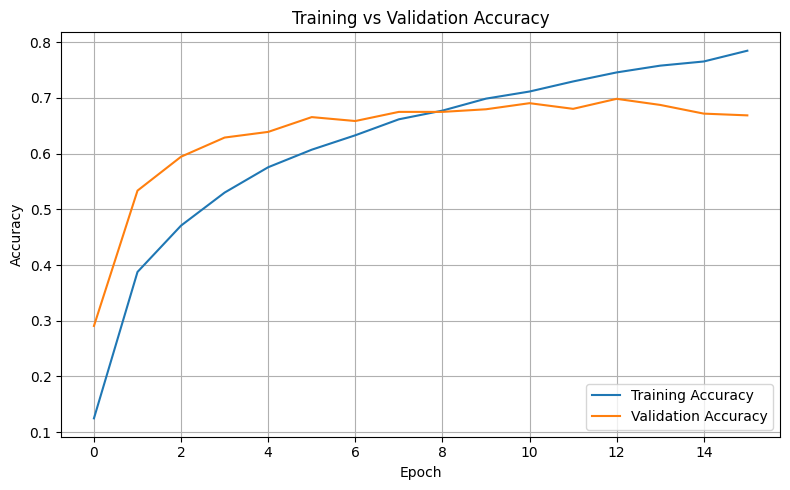

In [ ]:
plot_accuracy(history_aug)

In [ ]:
save_model_and_history(
    model=model_aug,
    history=history_aug,
    base_dir="/content/drive/MyDrive/Assignment#2",
    model_name="Modified_Aug_Model"
)

✅ Model saved to: /content/drive/MyDrive/Assignment#2/Modified_Aug_Model.keras
✅ History saved to: /content/drive/MyDrive/Assignment#2/Modified_Aug_Model_history.json


----------------------------------------------

# Evaluation

In [58]:
import os

folder_path = "/content/drive/MyDrive/Assignment#2"
print("📁 Contents of folder:")
for item in os.listdir(folder_path):
    print("—", item)

📁 Contents of folder:
— Modified_Aug_Model.keras
— Modified_Aug_Model_history.json
— Modified_No_Aug_Model.keras
— Modified_No_Aug_Model_history.json
— No_Aug_Model.keras
— No_Aug_Model_history.json
— The Destined One.keras
— The Destined One_history.json
— Aug_Model.keras
— Aug_Model_history.json


In [59]:
import tensorflow_datasets as tfds

test_ds = tfds.load(
    "stanford_dogs",
    split="test",
    as_supervised=True
)

In [60]:
test_ds = test_ds.map(
    lambda x, y: preprocess_data(x, y, augment=False),
    num_parallel_calls=tf.data.AUTOTUNE
)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

## 120 Class Breeds

###No Augmentation Model

In [61]:
from tensorflow.keras.models import load_model

model_no_aug = load_model("/content/drive/MyDrive/Assignment#2/No_Aug_Model.keras")

model_no_aug.evaluate(test_ds)

269/269 ━━━━━━━━━━━━━━━━━━━━ 40s 95ms/step - accuracy: 0.5347 - loss: 2.4507


[2.4379189014434814, 0.5351981520652771]

###Augmentation Model

In [64]:
from tensorflow.keras.models import load_model

model_aug = load_model("/content/drive/MyDrive/Assignment#2/Aug_Model.keras")

model_aug.evaluate(test_ds)

269/269 ━━━━━━━━━━━━━━━━━━━━ 49s 122ms/step - accuracy: 0.4154 - loss: 3.3447


[3.3002333641052246, 0.42424243688583374]

###Augmentation + Expansion (The Destined One)

In [65]:
from tensorflow.keras.models import load_model

model_aug_mod = load_model("/content/drive/MyDrive/Assignment#2/The Destined One.keras")

model_aug_mod.evaluate(test_ds)

269/269 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.5668 - loss: 2.5055


[2.4971959590911865, 0.570629358291626]

In [66]:
test_loss_no_aug, test_acc_no_aug = model_no_aug.evaluate(test_ds, verbose=0)
test_loss_aug, test_acc_aug = model_aug.evaluate(test_ds, verbose=0)
test_loss_aug_mod, test_acc_aug_mod = model_aug_mod.evaluate(test_ds, verbose=0)

print("Test Results:")
print(f"NO AUG     → Accuracy: {test_acc_no_aug:.4f} | Loss: {test_loss_no_aug:.4f}")
print(f"AUGMENTED  → Accuracy: {test_acc_aug:.4f} | Loss: {test_loss_aug:.4f}")
print(f"The Destined One  → Accuracy: {test_acc_aug_mod:.4f} | Loss: {test_loss_aug_mod:.4f}")

Test Results:
NO AUG     → Accuracy: 0.5352 | Loss: 2.4379
AUGMENTED  → Accuracy: 0.4242 | Loss: 3.3002
The Destined One  → Accuracy: 0.5706 | Loss: 2.4972


In [68]:

def plot_training_metrics(history1, history2,history3, label1="No Aug", label2="Aug" , label3="Aug_mod"):
    # Train Loss
    plt.figure(figsize=(10, 6))
    plt.plot(history1['loss'], label=f'{label1} Train Loss')
    plt.plot(history2['loss'], label=f'{label2} Train Loss')
    plt.plot(history3['loss'], label=f'{label3} Train Loss')

    plt.title('Train Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Val Loss
    plt.figure(figsize=(10, 6))
    plt.plot(history1['val_loss'], label=f'{label1} Val Loss')
    plt.plot(history2['val_loss'], label=f'{label2} Val Loss')
    plt.plot(history3['val_loss'], label=f'{label3} Val Loss')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Train Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(history1['accuracy'], label=f'{label1} Train Accuracy')
    plt.plot(history2['accuracy'], label=f'{label2} Train Accuracy')
    plt.plot(history3['accuracy'], label=f'{label3} Train Accuracy')
    plt.title('Train Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Val Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(history1['val_accuracy'], label=f'{label1} Val Accuracy')
    plt.plot(history2['val_accuracy'], label=f'{label2} Val Accuracy')
    plt.plot(history3['val_accuracy'], label=f'{label3} Val Accuracy')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

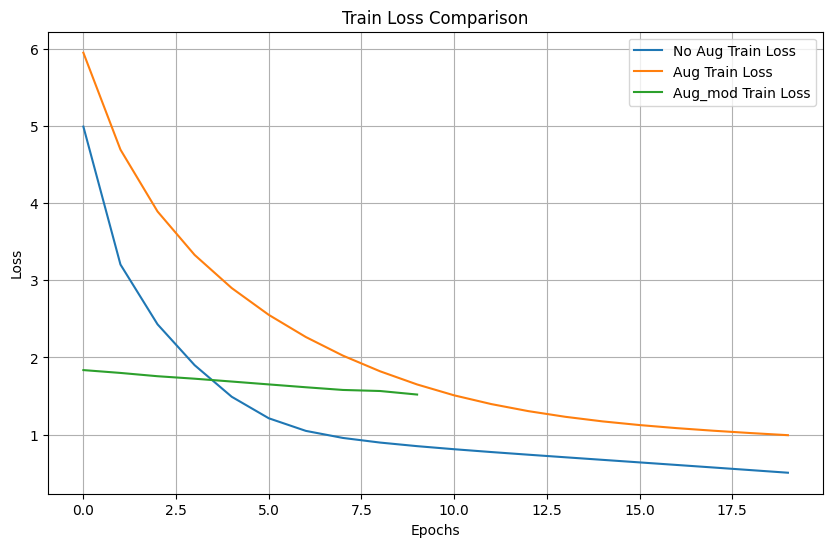

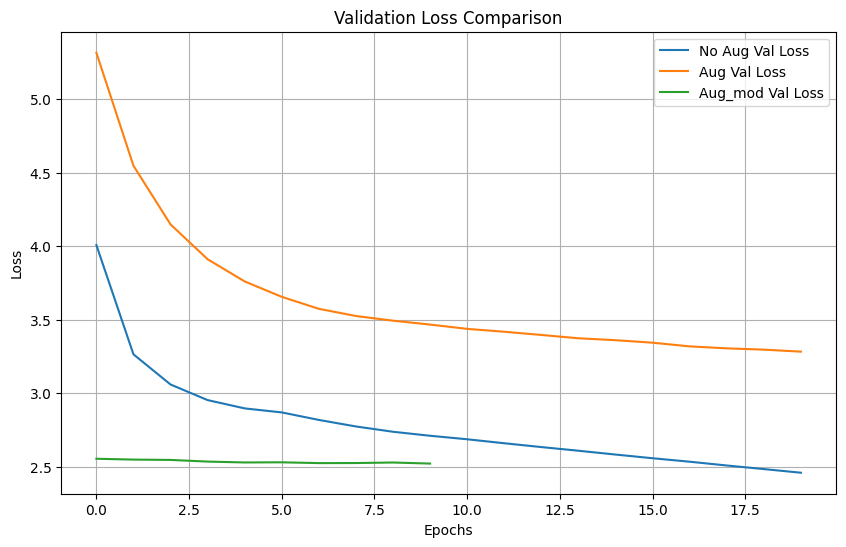

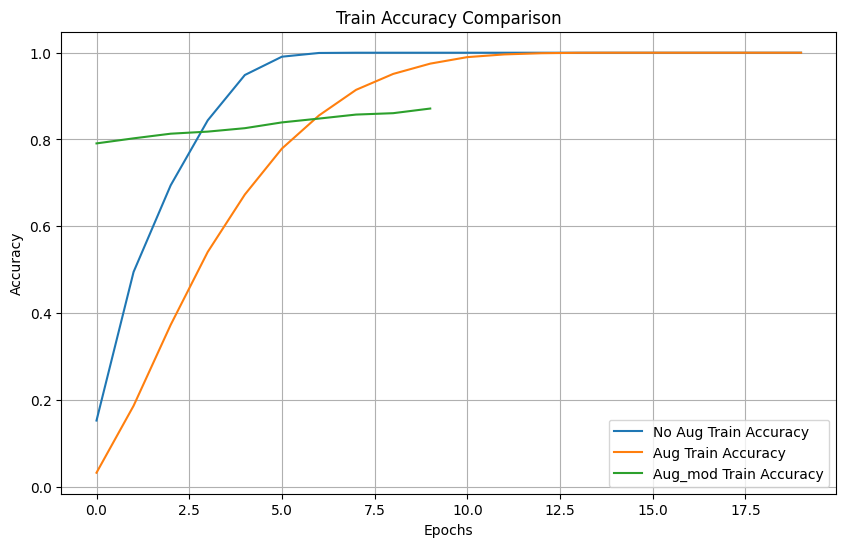

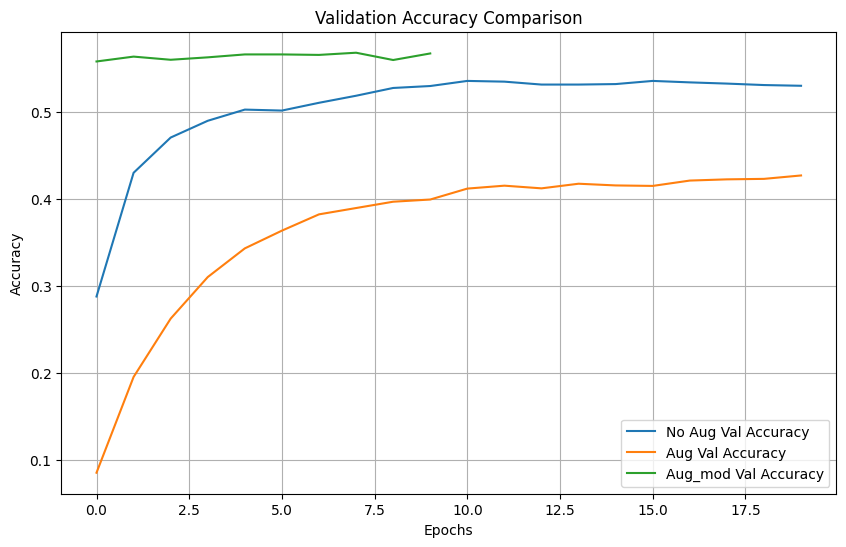

In [71]:
import json

with open('/content/drive/MyDrive/Assignment#2/No_Aug_Model_history.json') as f:
    hist_no_aug = json.load(f)

with open('/content/drive/MyDrive/Assignment#2/Aug_Model_history.json') as f:
    hist_aug = json.load(f)

with open('/content/drive/MyDrive/Assignment#2/The Destined One_history.json') as f:
    hist_aug_mod = json.load(f)


plot_training_metrics(hist_no_aug, hist_aug,hist_aug_mod, label1="No Aug", label2="Aug" , label3="Aug_mod")

## 50 Class Breeds

In [82]:
test_ds_mod = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

###No Augmentation

In [83]:
from tensorflow.keras.models import load_model

model_no_aug_modified = load_model("/content/drive/MyDrive/Assignment#2/Modified_No_Aug_Model.keras")

model_no_aug_modified.evaluate(test_ds_mod)

15/15 ━━━━━━━━━━━━━━━━━━━━ 36s 873ms/step - accuracy: 0.6641 - loss: 2.2137


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


[2.2137467861175537, 0.6490066051483154]

###Augmentation Model

In [84]:
from tensorflow.keras.models import load_model

model_aug_modified = load_model("/content/drive/MyDrive/Assignment#2/Modified_Aug_Model.keras")

model_aug_modified.evaluate(test_ds_mod)

15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 732ms/step - accuracy: 0.6110 - loss: 2.1953


[2.1197643280029297, 0.6335541009902954]

In [85]:
test_loss_no_aug_modified, test_acc_no_aug_modified = model_no_aug_modified.evaluate(test_ds_mod, verbose=0)
test_loss_aug_modified, test_acc_aug_modified = model_aug_modified.evaluate(test_ds_mod, verbose=0)

print("Test Results:")
print(f"NO AUG     → Accuracy: {test_acc_no_aug_modified:.4f} | Loss: {test_loss_no_aug_modified:.4f}")
print(f"AUGMENTED  → Accuracy: {test_acc_aug_modified:.4f} | Loss: {test_loss_aug_modified:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Test Results:
NO AUG     → Accuracy: 0.6490 | Loss: 2.2137
AUGMENTED  → Accuracy: 0.6336 | Loss: 2.1198


In [86]:
def plot_training_metrics(history1, history2, label1="No Aug", label2="Aug"):
    # Train Loss
    plt.figure(figsize=(10, 6))
    plt.plot(history1['loss'], label=f'{label1} Train Loss')
    plt.plot(history2['loss'], label=f'{label2} Train Loss')
    plt.title('Train Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Val Loss
    plt.figure(figsize=(10, 6))
    plt.plot(history1['val_loss'], label=f'{label1} Val Loss')
    plt.plot(history2['val_loss'], label=f'{label2} Val Loss')
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Train Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(history1['accuracy'], label=f'{label1} Train Accuracy')
    plt.plot(history2['accuracy'], label=f'{label2} Train Accuracy')
    plt.title('Train Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Val Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(history1['val_accuracy'], label=f'{label1} Val Accuracy')
    plt.plot(history2['val_accuracy'], label=f'{label2} Val Accuracy')
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

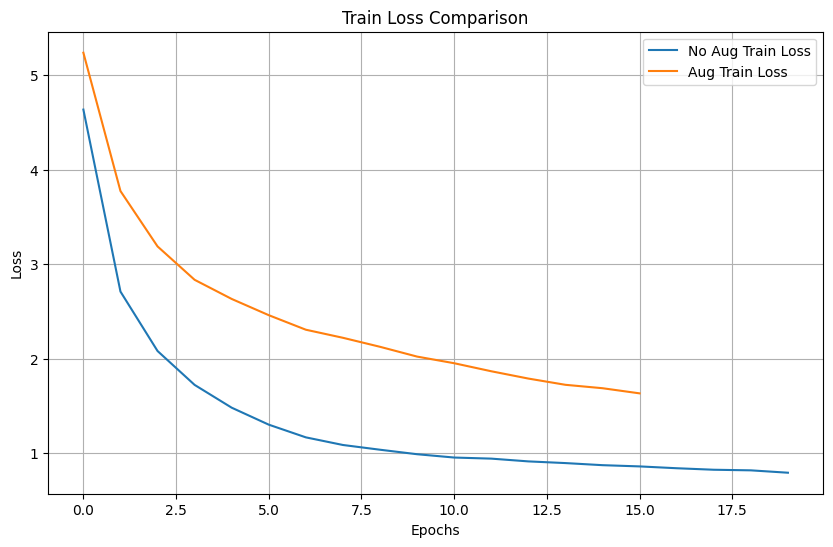

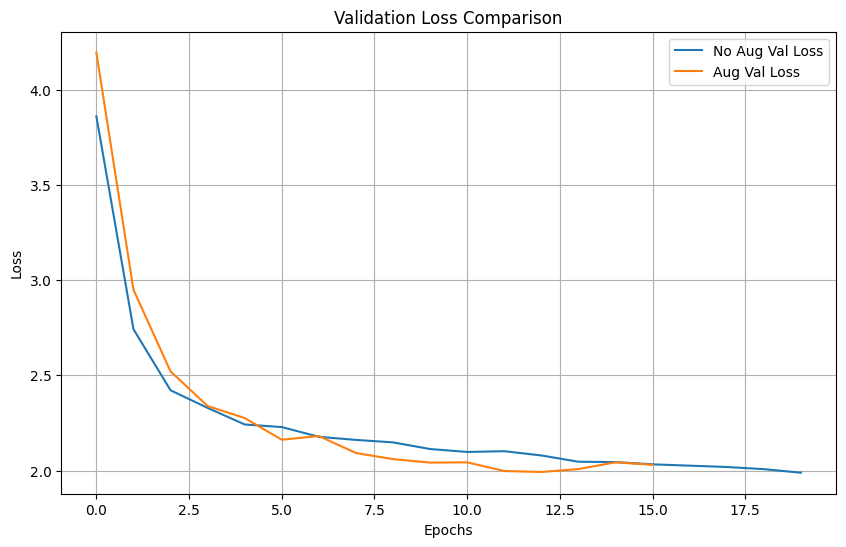

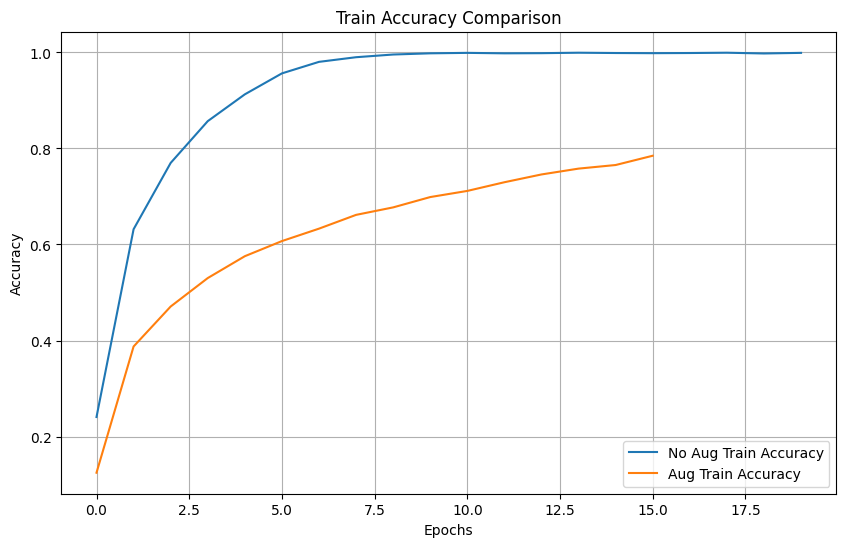

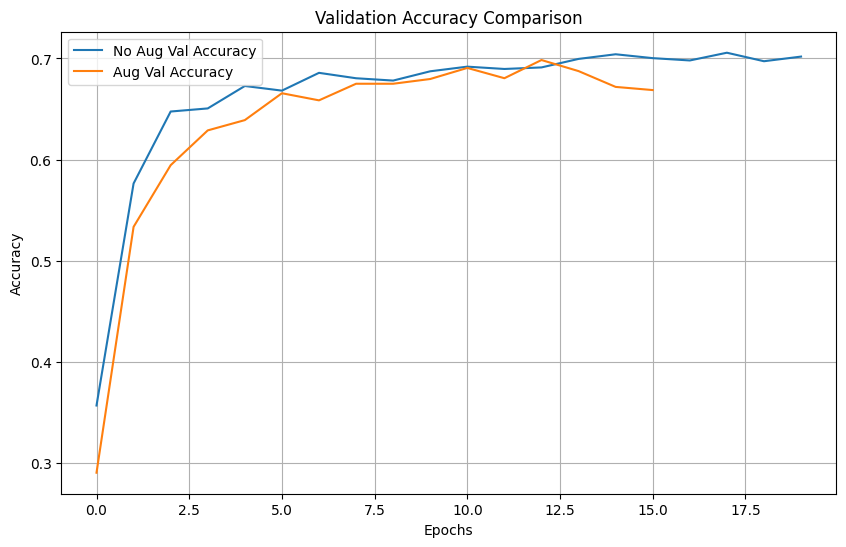

In [88]:
import json

with open('/content/drive/MyDrive/Assignment#2/Modified_No_Aug_Model_history.json') as f:
    hist_no_aug = json.load(f)

with open('/content/drive/MyDrive/Assignment#2/Modified_Aug_Model_history.json') as f:
    hist_aug = json.load(f)

plot_training_metrics(hist_no_aug, hist_aug, label1="No Aug", label2="Aug")

**Results Table**

In [96]:
def print_metrics_table(results_dict, title="Results Summary"):
    headers = ["Model", "Train Loss", "Train Accuracy", "Val Loss", "Val Accuracy"]
    col_widths = [30, 12, 15, 12, 15]

    total_width = sum(col_widths) + len(col_widths)*3 + 1
    separator = "+" + "+".join(["-" * (w + 2) for w in col_widths]) + "+"

    print(separator)
    print("|" + f" {title.center(total_width - 2)} " + "|")
    print(separator)

    print("|", end="")
    for h, w in zip(headers, col_widths):
        print(f" {h:<{w}} |", end="")
    print()
    print(separator)

    for model_name, metrics in results_dict.items():
        print("|", end="")
        print(f" {model_name:<{col_widths[0]}} |", end="")
        print(f" {metrics['Train Loss']:<{col_widths[1]}.4f} |", end="")
        print(f" {metrics['Train Acc']:<{col_widths[2]}.4f} |", end="")
        print(f" {metrics['Val Loss']:<{col_widths[3]}.4f} |", end="")
        print(f" {metrics['Val Acc']:<{col_widths[4]}.4f} |", end="")
        print()
    print(separator)


In [91]:
import json

# Load the saved histories
with open("/content/drive/MyDrive/Assignment#2/Aug_Model_history.json", "r") as f:
    history_no_aug = json.load(f)

with open("/content/drive/MyDrive/Assignment#2/No_Aug_Model_history.json", "r") as f:
    history_aug = json.load(f)

with open("/content/drive/MyDrive/Assignment#2/The Destined One_history.json", "r") as f:
    history_aug_exp = json.load(f)

with open("/content/drive/MyDrive/Assignment#2/Modified_No_Aug_Model_history.json", "r") as f:
    history_aug_no_mod = json.load(f)

with open("/content/drive/MyDrive/Assignment#2/Modified_Aug_Model_history.json", "r") as f:
    history_aug_mod = json.load(f)


# Store results
results = {
    "Pretrained_no_aug": get_final_metrics_from_history(history_no_aug),
    "Pretrained_aug": get_final_metrics_from_history(history_aug),
    "Pretrained_aug_exp" : get_final_metrics_from_history(history_aug_exp),
    "Modified_Pretrained_no_aug": get_final_metrics_from_history(history_aug_no_mod),
    "Modified_Pretrained_aug": get_final_metrics_from_history(history_aug_mod)
}


In [97]:
import os
import json

# Define base paths to the saved history files
base_path = "/content/drive/MyDrive/Assignment#2"

history_files = {
    "Pretrained_no_aug": "/content/drive/MyDrive/Assignment#2/Aug_Model_history.json",
    "Pretrained_aug": "/content/drive/MyDrive/Assignment#2/No_Aug_Model_history.json",
    "Pretrained_aug_exp": "/content/drive/MyDrive/Assignment#2/The Destined One_history.json",
    "Modified_Pretrained_no_aug": "/content/drive/MyDrive/Assignment#2/Modified_No_Aug_Model_history.json",
    "Modified_Pretrained_aug": "/content/drive/MyDrive/Assignment#2/Modified_Aug_Model_history.json",
}

# Dictionary to store final results
results = {}

# Load history and compute metrics
for model_name, path in history_files.items():
    if os.path.exists(path):
        with open(path, "r") as f:
            history = json.load(f)
            results[model_name] = get_final_metrics_from_history(history)
    else:
        print(f"❌ Missing history file for {model_name}: {path}")

# Print results in a formatted table
print_metrics_table(results, title="Pretrained Model Metrics")

+--------------------------------+--------------+-----------------+--------------+-----------------+
|                                      Pretrained Model Metrics                                      |
+--------------------------------+--------------+-----------------+--------------+-----------------+
| Model                          | Train Loss   | Train Accuracy  | Val Loss     | Val Accuracy    |
+--------------------------------+--------------+-----------------+--------------+-----------------+
| Pretrained_no_aug              | 0.9930       | 1.0000          | 3.2816       | 0.4269          |
| Pretrained_aug                 | 0.5068       | 1.0000          | 2.4579       | 0.5299          |
| Pretrained_aug_exp             | 1.5193       | 0.8713          | 2.5201       | 0.5670          |
| Modified_Pretrained_no_aug     | 0.7933       | 0.9991          | 1.9888       | 0.7018          |
| Modified_Pretrained_aug        | 1.6326       | 0.7848          | 2.0303       | 0.6687

## **Analysis**

**📉 Why Is the Loss Relatively High Despite Good Accuracy?**


In this project, the model achieved strong classification accuracy (~56–64%) on a fine-grained dataset with 120 classes. However, the corresponding categorical crossentropy loss remained relatively high (above 2.5). This is expected and can be explained by the nature of the loss function and problem setup:


The relatively high loss, despite achieving strong accuracy, is expected due to the complexity of classifying 120 fine-grained dog breeds. Categorical crossentropy penalizes low-confidence predictions even if correct, and many breeds in the dataset are visually similar, reducing prediction confidence. Additionally, L2 regularization was applied to prevent overfitting by penalizing large weights, which slightly increases the reported loss. Overall, the higher loss reflects the difficulty of the task and the use of regularization, not poor model performance.

After we tried all possible tweaks on the architecture — dropout, L2 regularization, fine-tuning the backbone, even adjusting learning rates and batch sizes — one thing stayed constant:

**The validation accuracy always plateaued around 50–52%, no matter how high the training accuracy went**.

It didn’t matter if the model hit 80% or even 100% training acc — **the validation just sat there.**

I dont think we can **"solve"** 120 breeds with 12k samples — each breed could have maybe less than a 100 images no way can deep networks learn this way , even with expansion it still didnt yield perfect results this is *our journey's final destination*